# Base

In [20]:
import pandas as pd

df = pd.read_csv('Data/Customer-Churn-Records.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

y = df['Exited'].astype(int)

df= df[['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'EstimatedSalary',
       'Exited', 'Satisfaction Score',
       'Point Earned']]

df = pd.DataFrame(df)
label_encoder = LabelEncoder()

    
X=df.drop(['Exited'], axis=1)

In [22]:
import numpy as np
import optuna
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from imblearn.over_sampling import SMOTE

# Ghi lại thời gian bắt đầu toàn bộ quá trình chạy
overall_start_time = time.time()

# Chia tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để cân bằng dữ liệu huấn luyện
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

def objective(trial):
    """Hàm mục tiêu Optuna để tìm siêu tham số tối ưu."""
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tối ưu siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Thiết lập số lần thử là 200

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực hiện tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian chạy tìm kiếm siêu tham số: {total_time:.2f} Giây")

# Lấy ra siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tối ưu:", best_params)

# Huấn luyện lại mô hình với siêu tham số tối ưu
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_resampled, y_resampled)

# Thực hiện dự đoán
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình chạy
overall_end_time = time.time()

# Tính tổng thời gian chạy toàn bộ
overall_total_time = overall_end_time - overall_start_time
print(f"Toàn bộ thời gian chạy: {overall_total_time:.2f} Giây")


[I 2025-06-17 22:12:41,858] A new study created in memory with name: no-name-d7dc62a6-6e04-4a21-b8e2-2de00347edf1


[I 2025-06-17 22:12:43,460] Trial 0 finished with value: 0.8098744202764304 and parameters: {'n_estimators': 157, 'max_depth': 44, 'min_samples_split': 18, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.8098744202764304.
[I 2025-06-17 22:12:46,930] Trial 1 finished with value: 0.8104840305850199 and parameters: {'n_estimators': 334, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.8104840305850199.
[I 2025-06-17 22:12:51,398] Trial 2 finished with value: 0.8079157502719495 and parameters: {'n_estimators': 362, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8104840305850199.
[I 2025-06-17 22:12:54,503] Trial 3 finished with value: 0.8108830482415514 and parameters: {'n_estimators': 347, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 3 with value: 0.8108830482415514.
[I 2025-06-17 22:12:57,003] Trial 4 finished with value: 0.811654165696832 and parameter

Thời gian chạy tìm kiếm siêu tham số: 609.05 Giây
Siêu tham số tối ưu: {'n_estimators': 243, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 11}
AUC: 0.812422116345315
Accuracy: 0.7735
Precision: 0.44932432432432434
Recall: 0.6768447837150128
F1 Score: 0.5401015228426396
Matthews Correlation Coefficient: 0.41257619220869324

Ma trận nhầm lẫn:
[[1281  326]
 [ 127  266]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1607
           1       0.45      0.68      0.54       393

    accuracy                           0.77      2000
   macro avg       0.68      0.74      0.69      2000
weighted avg       0.82      0.77      0.79      2000

Toàn bộ thời gian chạy: 611.65 Giây


In [23]:
import numpy as np
import optuna
import time
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from imblearn.over_sampling import SMOTE

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tính toán scale_pos_weight (có thể dùng nếu không dùng SMOTE)
# scale_pos_weight = sum(y_resampled == 0) / sum(y_resampled == 1)

def objective(trial):
    """Hàm mục tiêu Optuna để tìm siêu tham số tối ưu."""
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=scale_pos_weight,  # Dành cho dữ liệu không cân bằng
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbosity=0,
        use_label_encoder=False
    )
    
    model.fit(X_resampled, y_resampled)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Thiết lập chạy 200 lần thử

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian chạy tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian chạy tìm kiếm siêu tham số: {total_time:.2f} Giây")

# Lấy ra siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tối ưu:", best_params)

# Huấn luyện lại mô hình với siêu tham số tối ưu
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    # scale_pos_weight=scale_pos_weight,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    verbosity=0,
    use_label_encoder=False
)
best_model.fit(X_resampled, y_resampled)

# Dự đoán
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính toán các chỉ số đánh giá
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian chạy toàn bộ
overall_total_time = overall_end_time - overall_start_time
print(f"Toàn bộ thời gian chạy: {overall_total_time:.2f} Giây")


[I 2025-06-17 22:22:53,515] A new study created in memory with name: no-name-8be383c6-7ad1-4fcc-8c05-8758799da94d
[I 2025-06-17 22:22:53,770] Trial 0 finished with value: 0.7808443023603794 and parameters: {'max_depth': 10, 'learning_rate': 0.26492998243839305, 'n_estimators': 202}. Best is trial 0 with value: 0.7808443023603794.
[I 2025-06-17 22:22:53,988] Trial 1 finished with value: 0.8098364185948562 and parameters: {'max_depth': 4, 'learning_rate': 0.019669745516327025, 'n_estimators': 465}. Best is trial 1 with value: 0.8098364185948562.
[I 2025-06-17 22:22:54,087] Trial 2 finished with value: 0.79098600113055 and parameters: {'max_depth': 7, 'learning_rate': 0.1345144000096361, 'n_estimators': 101}. Best is trial 1 with value: 0.8098364185948562.
[I 2025-06-17 22:22:54,190] Trial 3 finished with value: 0.7998736444087651 and parameters: {'max_depth': 7, 'learning_rate': 0.08882918373652898, 'n_estimators': 106}. Best is trial 1 with value: 0.8098364185948562.
[I 2025-06-17 22:22

Thời gian chạy tìm kiếm siêu tham số: 20.15 Giây
Siêu tham số tối ưu: {'max_depth': 5, 'learning_rate': 0.010044784667456052, 'n_estimators': 123}
AUC: 0.8214570161396308
Accuracy: 0.7575
Precision: 0.4298780487804878
Recall: 0.7175572519083969
F1 Score: 0.5376549094375596
Matthews Correlation Coefficient: 0.4103345367601484

Ma trận nhầm lẫn:
[[1233  374]
 [ 111  282]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1607
           1       0.43      0.72      0.54       393

    accuracy                           0.76      2000
   macro avg       0.67      0.74      0.69      2000
weighted avg       0.82      0.76      0.78      2000

Toàn bộ thời gian chạy: 20.24 Giây


# Highly Associated Fuzzy Churn Patterns in Binary Classification

## Fuzzy Triangle & Gaussion

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('Data/Customer-Churn-Records.csv')


#print(df_encoded.columns)
y = df['Exited'].astype(int)
#df_encoded = df.astype(float)
#df_encoded
#X=df_encoded.drop(['Churn'], axis=1)

df= df[['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Satisfaction Score', 
       'Point Earned']]

df = pd.DataFrame(df)

# LabelEncoder
label_encoder = LabelEncoder()

    
X=df.drop(['Exited'], axis=1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_temp=pd.concat([X_temp,y_temp],axis=1)
X=X_temp[X_temp['Exited']==1]

X

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Exited
471,703,37,1,149762.08,1,0,20629.40,3,371,1
3046,658,31,3,133003.03,1,1,146339.27,3,879,1
3617,792,29,4,107601.79,1,0,18922.18,1,510,1
3114,619,40,10,0.00,1,1,147093.84,3,298,1
3146,548,28,8,116755.50,2,1,158585.17,1,519,1
...,...,...,...,...,...,...,...,...,...,...
2289,644,48,8,0.00,2,1,44965.54,4,930,1
3783,647,26,8,109958.15,1,1,136592.24,2,271,1
860,667,43,8,190227.46,1,0,97508.04,3,680,1
8147,642,39,8,128264.03,1,0,61792.76,1,280,1


In [2]:

Xtofuzzy_Tri  = X[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Satisfaction Score','Point Earned','IsActiveMember']]

In [4]:
import pandas as pd

# Membership function
def triangular_mf(x, a, b, c):
    if x <= a:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x <= c:
        return (c - x) / (c - b)
    else:
        return 0

# Maximal cardinality
def fuzzy_classification(x, min_val, median_val, max_val):
    low_membership = triangular_mf(x, min_val, min_val, median_val)
    medium_membership = triangular_mf(x, min_val, median_val, max_val)
    high_membership = triangular_mf(x, median_val, max_val, max_val)
    
    max_membership = max(low_membership, medium_membership, high_membership)
    
    if max_membership == low_membership:
        return 0
    elif max_membership == medium_membership:
        return 1
    else:
        return 2
  
    
fuzzy_df = pd.DataFrame()
# For each feature
for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    fuzzy_df[f'{feature}_fuzzy'] = Xtofuzzy_Tri[feature].apply(lambda x: fuzzy_classification(x, min_val, median_val, max_val))

fuzzy_df

# Define a dict
boundaries = {}

for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    # Save
    boundaries[feature] = (min_val, median_val, max_val)

# print out
for feature, bounds in boundaries.items():
    print(f"Feature: {feature}")
    print(f"Low boundary: {bounds[0]}, Medium boundary: {bounds[1]}, High boundary: {bounds[2]}")
    print("------")

fuzzy_df

Feature: CreditScore
Low boundary: 350, Medium boundary: 645.5, High boundary: 850
------
Feature: Age
Low boundary: 18, Medium boundary: 45.0, High boundary: 84
------
Feature: Tenure
Low boundary: 0, Medium boundary: 5.0, High boundary: 10
------
Feature: Balance
Low boundary: 0.0, Medium boundary: 108996.11499999999, High boundary: 250898.09
------
Feature: NumOfProducts
Low boundary: 1, Medium boundary: 1.0, High boundary: 4
------
Feature: EstimatedSalary
Low boundary: 11.58, Medium boundary: 100667.58, High boundary: 199808.1
------
Feature: Satisfaction Score
Low boundary: 1, Medium boundary: 3.0, High boundary: 5
------
Feature: Point Earned
Low boundary: 163, Medium boundary: 610.5, High boundary: 1000
------
Feature: IsActiveMember
Low boundary: 0, Medium boundary: 0.0, High boundary: 1
------


,CreditScore_fuzzy,Age_fuzzy,Tenure_fuzzy,Balance_fuzzy,NumOfProducts_fuzzy,EstimatedSalary_fuzzy,Satisfaction Score_fuzzy,Point Earned_fuzzy,IsActiveMember_fuzzy
471,1,1,0,1,0,0,1,0,0
3046,1,0,1,1,0,1,1,2,2
3617,2,0,1,1,0,0,0,1,0
3114,1,1,2,0,0,1,1,0,2
3146,1,0,2,1,1,2,0,1,2
...,...,...,...,...,...,...,...,...,...
2289,1,1,2,0,1,0,1,2,2
3783,1,0,2,1,0,1,0,0,2
860,1,1,2,2,0,1,1,1,0
8147,1,1,2,1,0,1,0,0,0


In [5]:
import pandas as pd
df_encoded=fuzzy_df
fuzzy_columns = [col for col in df_encoded.columns]

# one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=fuzzy_columns)

# 
for col in fuzzy_columns:
    mappings = {
        f"{col}_{i}": f"{col}_{i}" for i in range(3)
    }
    df_encoded.rename(columns=mappings, inplace=True)
df_encoded.columns

Index(['CreditScore_fuzzy_0', 'CreditScore_fuzzy_1', 'CreditScore_fuzzy_2',
       'Age_fuzzy_0', 'Age_fuzzy_1', 'Age_fuzzy_2', 'Tenure_fuzzy_0',
       'Tenure_fuzzy_1', 'Tenure_fuzzy_2', 'Balance_fuzzy_0',
       'Balance_fuzzy_1', 'Balance_fuzzy_2', 'NumOfProducts_fuzzy_0',
       'NumOfProducts_fuzzy_1', 'NumOfProducts_fuzzy_2',
       'EstimatedSalary_fuzzy_0', 'EstimatedSalary_fuzzy_1',
       'EstimatedSalary_fuzzy_2', 'Satisfaction Score_fuzzy_0',
       'Satisfaction Score_fuzzy_1', 'Satisfaction Score_fuzzy_2',
       'Point Earned_fuzzy_0', 'Point Earned_fuzzy_1', 'Point Earned_fuzzy_2',
       'IsActiveMember_fuzzy_0', 'IsActiveMember_fuzzy_2'],
      dtype='object')

In [6]:
import pandas as pd
df_encoded=fuzzy_df
fuzzy_columns = [col for col in df_encoded.columns]

# one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=fuzzy_columns)

# 
for col in fuzzy_columns:
    mappings = {
        f"{col}_{i}": f"{col}_{i}" for i in range(3)
    }
    df_encoded.rename(columns=mappings, inplace=True)
df_encoded.columns

Index(['CreditScore_fuzzy_0', 'CreditScore_fuzzy_1', 'CreditScore_fuzzy_2',
       'Age_fuzzy_0', 'Age_fuzzy_1', 'Age_fuzzy_2', 'Tenure_fuzzy_0',
       'Tenure_fuzzy_1', 'Tenure_fuzzy_2', 'Balance_fuzzy_0',
       'Balance_fuzzy_1', 'Balance_fuzzy_2', 'NumOfProducts_fuzzy_0',
       'NumOfProducts_fuzzy_1', 'NumOfProducts_fuzzy_2',
       'EstimatedSalary_fuzzy_0', 'EstimatedSalary_fuzzy_1',
       'EstimatedSalary_fuzzy_2', 'Satisfaction Score_fuzzy_0',
       'Satisfaction Score_fuzzy_1', 'Satisfaction Score_fuzzy_2',
       'Point Earned_fuzzy_0', 'Point Earned_fuzzy_1', 'Point Earned_fuzzy_2',
       'IsActiveMember_fuzzy_0', 'IsActiveMember_fuzzy_2'],
      dtype='object')

In [7]:
# Initialize dictionary to store dataset
dataset = {}

# Convert to transaction dataset
transaction_id = 1
for _, row in df_encoded.iterrows():
    transaction = {}
    for column, value in row.items():
        transaction[column] = value
    transaction_key = f'transaction{transaction_id}'
    dataset[transaction_key] = transaction
    transaction_id += 1

In [8]:
transactions = dataset

filtered_transactions = {transaction: {key: value for key, value in items.items() if value != 0}
                        for transaction, items in transactions.items()}

filtered_transactions

{'transaction1': {'CreditScore_fuzzy_1': True,
  'Age_fuzzy_1': True,
  'Tenure_fuzzy_0': True,
  'Balance_fuzzy_1': True,
  'NumOfProducts_fuzzy_0': True,
  'EstimatedSalary_fuzzy_0': True,
  'Satisfaction Score_fuzzy_1': True,
  'Point Earned_fuzzy_0': True,
  'IsActiveMember_fuzzy_0': True},
 'transaction2': {'CreditScore_fuzzy_1': True,
  'Age_fuzzy_0': True,
  'Tenure_fuzzy_1': True,
  'Balance_fuzzy_1': True,
  'NumOfProducts_fuzzy_0': True,
  'EstimatedSalary_fuzzy_1': True,
  'Satisfaction Score_fuzzy_1': True,
  'Point Earned_fuzzy_2': True,
  'IsActiveMember_fuzzy_2': True},
 'transaction3': {'CreditScore_fuzzy_2': True,
  'Age_fuzzy_0': True,
  'Tenure_fuzzy_1': True,
  'Balance_fuzzy_1': True,
  'NumOfProducts_fuzzy_0': True,
  'EstimatedSalary_fuzzy_0': True,
  'Satisfaction Score_fuzzy_0': True,
  'Point Earned_fuzzy_1': True,
  'IsActiveMember_fuzzy_0': True},
 'transaction4': {'CreditScore_fuzzy_1': True,
  'Age_fuzzy_1': True,
  'Tenure_fuzzy_2': True,
  'Balance_fuzzy

## High Utility fuzzy Churn Patterns

In [13]:
import time

def extract_base_name(fuzzy_name):
    if fuzzy_name.startswith("Status_"):
        return "Status"
    elif fuzzy_name.startswith("Age Group_"):
        return "Age Group"
    elif fuzzy_name.startswith("Tariff Plan_"):
        return "Tariff Plan"
    elif "fuzzy" in fuzzy_name:
        return fuzzy_name.split("_", 1)[0]
    else:
        return fuzzy_name

def calculate_utility(itemset, transactions, profit_table):
    total_utility = 0
    for transaction in transactions.values():
        if set(itemset).issubset(set(transaction.keys())):
            for item, utility in transaction.items():
                if item in itemset:
                    base_name = extract_base_name(item)
                    total_utility += utility * profit_table.get(base_name, 0)
    return total_utility

def find_top_k_high_utility_itemsets(transactions, profit_table, k):
    itemsets = set()
    for transaction in transactions.values():
        itemsets.update(transaction.keys())

    high_utility_itemsets = {}
    for item in itemsets:
        utility = calculate_utility([item], transactions, profit_table)
        if utility > 0:
            high_utility_itemsets[(item,)] = utility

    P_itemsets = {}
    while True:
        temp_itemsets = {}
        for itemset, utility in high_utility_itemsets.items():
            for item in itemsets:
                if item not in itemset:
                    new_itemset = tuple(sorted(list(itemset) + [item]))
                    new_utility = calculate_utility(new_itemset, transactions, profit_table)
                    if new_utility > 0:
                        temp_itemsets[new_itemset] = new_utility
                        P_itemsets[new_itemset] = new_utility

        if not temp_itemsets:
            break

        sorted_itemsets = sorted(temp_itemsets.items(), key=lambda x: x[1], reverse=True)
        top_k_itemsets = sorted_itemsets[:k]
        high_utility_itemsets = {itemset: utility for itemset, utility in top_k_itemsets}

    return high_utility_itemsets, P_itemsets

# Dữ liệu kiểm tra

# k = 10

# # Ghi lại thời gian bắt đầu
# start_time = time.time()

# # Thực thi hàm tìm top-k tập mục có độ hữu ích cao
# result = find_top_k_high_utility_itemsets(filtered_transactions, profit_table, k)

# # Ghi lại thời gian kết thúc
# end_time = time.time()

# # Tính thời gian thực thi
# execution_time = end_time - start_time
# print(f"Thời gian thực thi chương trình: {execution_time:.6f} giây")

# result


In [14]:
# SHAP - Bảng trọng số lợi nhuận từ các thuộc tính
profit_table = {
    "Age": 1.051942,
    "NumOfProducts": 0.944460,
    "Balance": 0.375520,
    "EstimatedSalary": 0.275761,
    "CreditScore": 0.285694,
    "Point Earned": 0.258406,
    "Tenure": 0.162138,
    "Satisfaction Score": 0.143929,
    "HasCrCard": 0.045952,
    "IsActiveMember": 0.510511,
    "Card Type": 0.088436,
    "Geography": 0.277061,
    "Gender": 0.293275
}

# Ghi lại thời gian bắt đầu
start_time = time.time()

# Lấy ra top 3 tập mục có độ hữu ích cao nhất
result, P_itemsets = find_top_k_high_utility_itemsets(filtered_transactions, profit_table, 3)

# Sắp xếp tất cả tập mục theo giá trị độ hữu ích giảm dần
sorted_data = sorted(P_itemsets.items(), key=lambda x: x[1], reverse=True)

# Lấy top 10 tập mục có độ hữu ích cao nhất
top_10 = sorted_data[:10]
top_10 = {itemset: value for itemset, value in top_10}

print("Top 10 tập mục có độ hữu ích cao nhất:")
for itemset, utility in top_10.items():
    print(itemset, "-> Độ hữu ích:", round(utility, 0))

# Ghi lại thời gian kết thúc
end_time = time.time()

# Tính thời gian thực thi chương trình
execution_time = end_time - start_time
print(f"Thời gian thực thi chương trình: {execution_time:.6f} giây")


Top 10 tập mục có độ hữu ích cao nhất:
('Age_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 2012.0
('Age_fuzzy_1', 'CreditScore_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1725.0
('Age_fuzzy_1', 'Balance_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1713.0
('Age_fuzzy_1', 'IsActiveMember_fuzzy_0', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1650.0
('Age_fuzzy_1', 'Balance_fuzzy_1') -> Độ hữu ích: 1496.0
('Age_fuzzy_1', 'CreditScore_fuzzy_1') -> Độ hữu ích: 1487.0
('Age_fuzzy_1', 'IsActiveMember_fuzzy_0') -> Độ hữu ích: 1469.0
('Age_fuzzy_1', 'Balance_fuzzy_1', 'CreditScore_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1438.0
('Age_fuzzy_1', 'CreditScore_fuzzy_1', 'IsActiveMember_fuzzy_0', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1377.0
('Age_fuzzy_1', 'Balance_fuzzy_1', 'IsActiveMember_fuzzy_0', 'NumOfProducts_fuzzy_0') -> Độ hữu ích: 1366.0
Thời gian thực thi chương trình: 0.723537 giây


In [15]:
def find_top_k_high_utility_itemsets(transactions, profit_table, k, desired_length):
    """
    Tìm ra K tập mục có độ hữu ích cao nhất với độ dài tối đa được chỉ định.
    """
    itemsets = set()
    for transaction in transactions.values():
        # Thêm từng mục trong giao dịch vào tập hợp itemsets
        itemsets.update(transaction.keys())

    # Lưu trữ các tập mục có độ hữu ích cao và tổng giá trị của chúng
    high_utility_itemsets = {}
    P_itemsets = {}

    # Tính độ hữu ích cho từng mục đơn lẻ
    for item in itemsets:
        utility = calculate_utility([item], transactions, profit_table)
        if utility > 0:
            high_utility_itemsets[(item,)] = utility

    while True:
        temp_itemsets = {}
        for itemset, utility in high_utility_itemsets.items():
            for item in itemsets:
                if item not in itemset:
                    # Tạo tập mục mới bằng cách kết hợp
                    new_itemset = tuple(sorted(list(itemset) + [item]))
                    new_utility = calculate_utility(new_itemset, transactions, profit_table)

                    # Kiểm tra điều kiện độ dài và độ hữu ích
                    if new_utility > 0 and len(new_itemset) <= desired_length:
                        temp_itemsets[new_itemset] = new_utility
                        P_itemsets[new_itemset] = new_utility

        # Nếu không còn tập mục nào mới được tạo, thoát vòng lặp
        if not temp_itemsets:
            break

        # Lấy top K tập mục có độ hữu ích cao nhất
        sorted_itemsets = sorted(temp_itemsets.items(), key=lambda x: x[1], reverse=True)
        top_k_itemsets = sorted_itemsets[:k]
        high_utility_itemsets = {itemset: utility for itemset, utility in top_k_itemsets}

    return high_utility_itemsets, P_itemsets


In [16]:
# SHAP
profit_table = {
   "Age": 1.051942,
    "NumOfProducts": 0.944460,
    "Balance": 0.375520,
    "EstimatedSalary": 0.275761,
    "CreditScore": 0.285694,
    "Point Earned": 0.258406,
    "Tenure": 0.162138,
    "Satisfaction Score": 0.143929,
    "HasCrCard": 0.045952,
    "IsActiveMember":0.510511,
    "Card Type":0.088436,
    "Geography":0.277061,
    "Gender":0.293275
}

# 取得前2個高效用項目集
result,P_itemsets= find_top_k_high_utility_itemsets(filtered_transactions, profit_table, 3,2)

# 輸出結果
#print(P_itemsets)
# 使用sorted函式將字典按數值降序排序
sorted_data = sorted(P_itemsets.items(), key=lambda x: x[1], reverse=True)

# 取得前5名的資料
top_10 = sorted_data[:10]
top_10 = {itemset: value for itemset, value in top_10}
#print(top_3)
print("Top 10 High Utility Itemsets:")
for itemset, utility in top_10.items():
    print(itemset, "-> Utility:", round(utility,0))

Top 10 High Utility Itemsets:
('Age_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Utility: 2012.0
('Age_fuzzy_1', 'Balance_fuzzy_1') -> Utility: 1496.0
('Age_fuzzy_1', 'CreditScore_fuzzy_1') -> Utility: 1487.0
('Age_fuzzy_1', 'IsActiveMember_fuzzy_0') -> Utility: 1469.0
('Balance_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Utility: 1077.0
('IsActiveMember_fuzzy_0', 'NumOfProducts_fuzzy_0') -> Utility: 1074.0
('CreditScore_fuzzy_1', 'NumOfProducts_fuzzy_0') -> Utility: 1043.0
('Age_fuzzy_1', 'Point Earned_fuzzy_1') -> Utility: 1027.0
('Age_fuzzy_1', 'EstimatedSalary_fuzzy_1') -> Utility: 968.0
('Age_fuzzy_1', 'Tenure_fuzzy_1') -> Utility: 852.0


In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('Data/Customer-Churn-Records.csv')



y = df['Exited'].astype(int)


df= df[['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Satisfaction Score', 
       'Point Earned']]

df = pd.DataFrame(df)

# LabelEncoder
label_encoder = LabelEncoder()   
    
X=df.drop(['Exited'], axis=1)



fuzzy_df = pd.DataFrame()
# Fuzzy classification
for feature in Xtofuzzy_Tri.columns:
    min_val = Xtofuzzy_Tri[feature].min()
    median_val = Xtofuzzy_Tri[feature].quantile(0.5)
    max_val = Xtofuzzy_Tri[feature].max()
    
    fuzzy_df[f'{feature}_fuzzy'] = Xtofuzzy_Tri[feature].apply(lambda x: fuzzy_classification(x, min_val, median_val, max_val))


df_fuzzy = pd.concat([fuzzy_df],axis=1)

fuzzy_columns = [col for col in df_fuzzy.columns]

# one-hot encoding
df_fuzzy = pd.get_dummies(df_fuzzy, columns=fuzzy_columns)
df_fuzzy =df_fuzzy.astype(int)
df_fuzzy

,CreditScore_fuzzy_0,CreditScore_fuzzy_1,CreditScore_fuzzy_2,Age_fuzzy_0,Age_fuzzy_1,Age_fuzzy_2,Tenure_fuzzy_0,Tenure_fuzzy_1,Tenure_fuzzy_2,Balance_fuzzy_0,...,EstimatedSalary_fuzzy_1,EstimatedSalary_fuzzy_2,Satisfaction Score_fuzzy_0,Satisfaction Score_fuzzy_1,Satisfaction Score_fuzzy_2,Point Earned_fuzzy_0,Point Earned_fuzzy_1,Point Earned_fuzzy_2,IsActiveMember_fuzzy_0,IsActiveMember_fuzzy_2
471,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3046,0,1,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
3617,0,0,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3114,0,1,0,0,1,0,0,0,1,1,...,1,0,0,1,0,1,0,0,0,1
3146,0,1,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,0,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,1,0,1
3783,0,1,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
860,0,1,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0
8147,0,1,0,0,1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0


In [18]:
X = pd.merge(df, df_fuzzy, left_index=True, right_index=True, how='left')
X['fuzzyp1']=X['Age_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp2']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp3']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp4']=X['Age_fuzzy_1']*X['NumOfProducts_fuzzy_0']*X['IsActiveMember_fuzzy_0']
X['fuzzyp5']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']
X['fuzzyp6']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']
X['fuzzyp7']=X['Age_fuzzy_1']*X['IsActiveMember_fuzzy_0']
X['fuzzyp8']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['CreditScore_fuzzy_1']*X['NumOfProducts_fuzzy_0']
X['fuzzyp9']=X['Age_fuzzy_1']*X['CreditScore_fuzzy_1']*X['IsActiveMember_fuzzy_0']*X['NumOfProducts_fuzzy_0']
X['fuzzyp10']=X['Age_fuzzy_1']*X['Balance_fuzzy_1']*X['IsActiveMember_fuzzy_0']*X['NumOfProducts_fuzzy_0']


#*X['Subscription  Length_fuzzy_1']*X['Tariff Plan_1']
#X=X[X['fuzzyp']==0]
#y=X[X['CHURN','fuzzyp']]
X=X.drop(['CreditScore_fuzzy_0', 'CreditScore_fuzzy_1', 'CreditScore_fuzzy_2',
       'Age_fuzzy_0', 'Age_fuzzy_1', 'Age_fuzzy_2', 'Tenure_fuzzy_0',
       'Tenure_fuzzy_1', 'Tenure_fuzzy_2', 'Balance_fuzzy_0',
       'Balance_fuzzy_1', 'Balance_fuzzy_2', 'NumOfProducts_fuzzy_0',
       'NumOfProducts_fuzzy_1', 'NumOfProducts_fuzzy_2',
       'IsActiveMember_fuzzy_0', 'IsActiveMember_fuzzy_2',
       'EstimatedSalary_fuzzy_0', 'EstimatedSalary_fuzzy_1',
       'EstimatedSalary_fuzzy_2', 
       'Satisfaction Score_fuzzy_0', 'Satisfaction Score_fuzzy_1',
       'Satisfaction Score_fuzzy_2', 'Point Earned_fuzzy_0',
       'Point Earned_fuzzy_1', 'Point Earned_fuzzy_2','Exited'],axis=1)
X = X.fillna(0)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,fuzzyp1,fuzzyp2,fuzzyp3,fuzzyp4,fuzzyp5,fuzzyp6,fuzzyp7,fuzzyp8,fuzzyp9,fuzzyp10
0,619,42,2,0.00,1,1,101348.88,2,464,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,608,41,1,83807.86,1,1,112542.58,3,456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,502,42,8,159660.80,3,0,113931.57,3,377,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,699,39,1,0.00,2,0,93826.63,5,350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,850,43,2,125510.82,1,1,79084.10,5,425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,0,96270.64,1,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,516,35,10,57369.61,1,1,101699.77,5,771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,709,36,7,0.00,1,1,42085.58,3,564,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,772,42,3,75075.31,2,0,92888.52,2,339,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### XGBoost


In [31]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report)
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import optuna

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tính toán tỷ lệ scale_pos_weight (nếu cần)
# scale_pos_weight = sum(y_resampled == 0) / sum(y_resampled == 1)

def objective(trial):
    """Hàm mục tiêu của Optuna để tìm siêu tham số tối ưu."""
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=scale_pos_weight,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbosity=0,
        use_label_encoder=False
    )
    
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # Thử tối đa 200 lần

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực thi cho quá trình tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian tìm kiếm siêu tham số: {total_time:.2f} giây")

# Lấy siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tốt nhất:", best_params)

# Huấn luyện lại mô hình với siêu tham số tốt nhất
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    # scale_pos_weight=scale_pos_weight,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    verbosity=0,
    use_label_encoder=False
)
best_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian thực thi
overall_total_time = overall_end_time - overall_start_time
print(f"Tổng thời gian thực thi: {overall_total_time:.2f} giây")


[I 2025-06-25 23:08:00,187] A new study created in memory with name: no-name-223a559e-be5f-4ae9-a0ee-51402f1e3736
[I 2025-06-25 23:08:00,329] Trial 0 finished with value: 0.9559544676518603 and parameters: {'max_depth': 4, 'learning_rate': 0.05982925895916052, 'n_estimators': 341}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,481] Trial 1 finished with value: 0.946379627298508 and parameters: {'max_depth': 3, 'learning_rate': 0.2966688084054261, 'n_estimators': 429}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,544] Trial 2 finished with value: 0.9538374573074858 and parameters: {'max_depth': 2, 'learning_rate': 0.22569062919522306, 'n_estimators': 205}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:00,595] Trial 3 finished with value: 0.9554311528285125 and parameters: {'max_depth': 4, 'learning_rate': 0.11274700590350946, 'n_estimators': 117}. Best is trial 0 with value: 0.9559544676518603.
[I 2025-06-25 23:08:

Thời gian tìm kiếm siêu tham số: 46.84 giây
Siêu tham số tốt nhất: {'max_depth': 10, 'learning_rate': 0.017080874302113958, 'n_estimators': 139}
AUC: 0.9606294661872121
Accuracy: 0.95
Precision: 0.9621451104100947
Recall: 0.7760814249363868
F1 Score: 0.8591549295774648
Matthews Correlation Coefficient: 0.8362591228563085

Ma trận nhầm lẫn:
[[1595   12]
 [  88  305]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1607
           1       0.96      0.78      0.86       393

    accuracy                           0.95      2000
   macro avg       0.95      0.88      0.91      2000
weighted avg       0.95      0.95      0.95      2000

Tổng thời gian thực thi: 47.02 giây


### Catboost

In [33]:
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
import time
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import optuna

# Ghi lại thời gian bắt đầu toàn bộ quá trình
overall_start_time = time.time()

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

def objective(trial):
    """Hàm mục tiêu của Optuna để tìm siêu tham số tối ưu."""
    depth = trial.suggest_int('depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    iterations = trial.suggest_int('iterations', 100, 500)
    
    model = CatBoostClassifier(
        objective='Logloss',
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        verbose=0
    )
    
    model.fit(X_resampled, y_resampled)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_prob)

# Ghi lại thời gian bắt đầu tìm kiếm siêu tham số
start_time = time.time()

# Thiết lập Optuna để tìm kiếm siêu tham số
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Ghi lại thời gian kết thúc tìm kiếm siêu tham số
end_time = time.time()

# Tính thời gian thực thi cho quá trình tìm kiếm siêu tham số
total_time = end_time - start_time
print(f"Thời gian tìm kiếm siêu tham số: {total_time:.2f} giây")

# Lấy siêu tham số tốt nhất
best_params = study.best_params
print("Siêu tham số tốt nhất:", best_params)

# Huấn luyện lại mô hình với siêu tham số tốt nhất
best_model = CatBoostClassifier(
    objective='Logloss',
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    verbose=0
)
best_model.fit(X_resampled, y_resampled)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ghi lại thời gian kết thúc toàn bộ quá trình
overall_end_time = time.time()

# Tính tổng thời gian thực thi
overall_total_time = overall_end_time - overall_start_time
print(f"Tổng thời gian thực thi: {overall_total_time:.2f} giây")


[I 2025-06-25 23:12:52,925] A new study created in memory with name: no-name-01968932-fdb6-443b-9e8a-20c6f17283ce
[I 2025-06-25 23:12:54,582] Trial 0 finished with value: 0.948290795201021 and parameters: {'depth': 4, 'learning_rate': 0.04636729830309406, 'iterations': 255}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:12:56,977] Trial 1 finished with value: 0.9425683753172744 and parameters: {'depth': 6, 'learning_rate': 0.13495721749403947, 'iterations': 490}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:13:01,172] Trial 2 finished with value: 0.940454531779698 and parameters: {'depth': 9, 'learning_rate': 0.2982955881757329, 'iterations': 484}. Best is trial 0 with value: 0.948290795201021.
[I 2025-06-25 23:13:02,064] Trial 3 finished with value: 0.9484887206258875 and parameters: {'depth': 2, 'learning_rate': 0.053744922810551043, 'iterations': 311}. Best is trial 3 with value: 0.9484887206258875.
[I 2025-06-25 23:13:03,624] Trial 4 finished wi

Thời gian tìm kiếm siêu tham số: 469.42 giây
Siêu tham số tốt nhất: {'depth': 10, 'learning_rate': 0.06498765715694237, 'iterations': 193}
AUC: 0.9527433255588227
Accuracy: 0.9495
Precision: 0.9451219512195121
Recall: 0.7888040712468194
F1 Score: 0.8599167822468793
Matthews Correlation Coefficient: 0.834463076758777

Ma trận nhầm lẫn:
[[1589   18]
 [  83  310]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1607
           1       0.95      0.79      0.86       393

    accuracy                           0.95      2000
   macro avg       0.95      0.89      0.91      2000
weighted avg       0.95      0.95      0.95      2000

Tổng thời gian thực thi: 471.98 giây


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report)

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thống kê phân phối lớp trước khi áp dụng SMOTE
print("Trước SMOTE: ", dict(zip(*np.unique(y_train, return_counts=True))))

# Áp dụng SMOTE để tạo mẫu tổng hợp, xử lý mất cân bằng lớp
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Thống kê phân phối lớp sau khi áp dụng SMOTE
print("Sau SMOTE: ", dict(zip(*np.unique(y_resampled, return_counts=True))))

# Khởi tạo mô hình Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu y_train được cân bằng
rf_classifier.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_classifier.predict(X_test)

# Lấy xác suất dự đoán để tính AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Đánh giá mô hình
auc_score = roc_auc_score(y_test, y_prob)
print("AUC:", auc_score)
print("Độ chính xác (Accuracy):", accuracy_score(y_test, y_pred))
print("Độ chính xác từng lớp (Precision):", precision_score(y_test, y_pred))
print("Khả năng thu hồi (Recall):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Hệ số tương quan Matthews:", matthews_corrcoef(y_test, y_pred))
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))


Trước SMOTE:  {0: 6355, 1: 1645}
Sau SMOTE:  {0: 6355, 1: 6355}
AUC: 0.9522904721867275
Độ chính xác (Accuracy): 0.951
Độ chính xác từng lớp (Precision): 0.9742765273311897
Khả năng thu hồi (Recall): 0.7709923664122137
F1 Score: 0.8607954545454546
Hệ số tương quan Matthews: 0.839935590908248

Ma trận nhầm lẫn:
[[1599    8]
 [  90  303]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1607
           1       0.97      0.77      0.86       393

    accuracy                           0.95      2000
   macro avg       0.96      0.88      0.92      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score)
from sdv.tabular import CTGAN
import matplotlib.pyplot as plt

# Tạo dữ liệu ví dụ (hoặc thay thế bằng dữ liệu thực của bạn)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.85, 0.15], flip_y=0, random_state=42)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thống kê phân phối lớp trước khi áp dụng GAN
print("Trước GAN: ", dict(zip(*np.unique(y_train, return_counts=True))))

# Chuyển X_train và y_train thành DataFrame
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X.shape[1])])
df_train['churn'] = y_train  # thêm nhãn

# Chọn chỉ những bản ghi thuộc lớp thiểu số để huấn luyện GAN
df_minority = df_train[df_train['churn'] == 1]

# Huấn luyện CTGAN
ctgan = CTGAN(epochs=300)
ctgan.fit(df_minority)

# Sinh thêm dữ liệu lớp thiểu số
n_samples_to_generate = df_train['churn'].value_counts()[0] - df_train['churn'].value_counts()[1]
synthetic_data = ctgan.sample(n_samples_to_generate)
print(f"Đã sinh thêm {len(synthetic_data)} bản ghi bằng GAN.")

# Gộp dữ liệu gốc và dữ liệu sinh
df_augmented = pd.concat([df_train, synthetic_data], ignore_index=True)

# Phân tách lại thành X_resampled và y_resampled
X_resampled = df_augmented.drop(columns=['churn']).values
y_resampled = df_augmented['churn'].values

# Thống kê phân phối sau khi thêm GAN
print("Sau GAN: ", dict(zip(*np.unique(y_resampled, return_counts=True))))

# Huấn luyện mô hình Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_resampled, y_resampled)

# Dự đoán trên tập kiểm tra
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Đánh giá mô hình
print("AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


ModuleNotFoundError: No module named 'sdv.tabular'

Phân phối ban đầu: {0: 6355, 1: 1645}
Đã sinh 4710 bản ghi bằng SDV.
Phân phối sau GAN: {0: 6355, 1: 6355}


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\lite\single_table.py:52: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\lite\single_table.py:61: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(META_DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:162: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:128: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for repli

AUC: 0.5
Accuracy: 0.1965
Precision: 0.1965
Recall: 1.0
F1 Score: 0.328458002507313
Matthews Corrcoef: 0.0

Confusion Matrix:
[[   0 1607]
 [   0  393]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1607
           1       0.20      1.00      0.33       393

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.16      2000
weighted avg       0.04      0.20      0.06      2000



c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

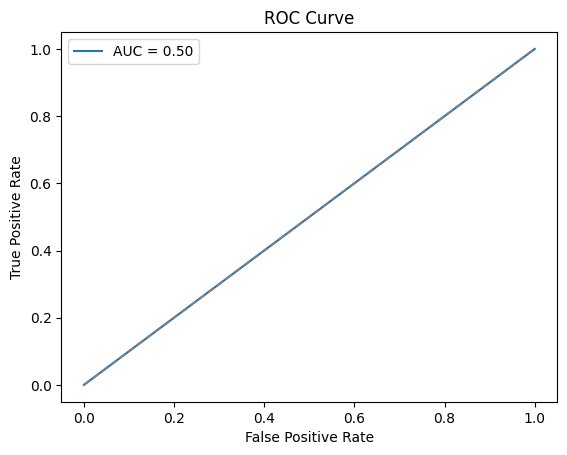

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve)
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset
import matplotlib.pyplot as plt

# 1. Tạo dữ liệu mẫu hoặc thay bằng dữ liệu thực
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
#                            weights=[0.85, 0.15], flip_y=0, random_state=42)

# 2. Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Phân phối ban đầu:", dict(zip(*np.unique(y_train, return_counts=True))))

# 3. Chuyển về DataFrame và thêm nhãn
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X.shape[1])])
df_train['churn'] = y_train

# 4. Lọc lớp thiểu số (churn = 1)
df_minority = df_train[df_train['churn'] == 1]

# 5. Số lượng cần sinh thêm
majority_count = df_train['churn'].value_counts()[0]
minority_count = df_train['churn'].value_counts()[1]
num_samples_to_generate = majority_count - minority_count

# 6. Khởi tạo metadata cho dữ liệu
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_minority)

# 7. Huấn luyện mô hình sinh dữ liệu
model = SingleTablePreset(name='FAST_ML', metadata=metadata)
model.fit(df_minority)

# 8. Sinh dữ liệu mới
synthetic_data = model.sample(num_rows=num_samples_to_generate)
print(f"Đã sinh {len(synthetic_data)} bản ghi bằng SDV.")

# 9. Gộp lại dữ liệu gốc và dữ liệu sinh
df_augmented = pd.concat([df_train, synthetic_data], ignore_index=True)

# 10. Tách lại X, y
X_resampled = df_augmented.drop(columns=['churn']).values
y_resampled = df_augmented['churn'].values

# 11. Kiểm tra phân phối mới
print("Phân phối sau GAN:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 12. Huấn luyện mô hình
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# 13. Dự đoán và đánh giá
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Matthews Corrcoef:", matthews_corrcoef(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 14. Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
